Turnning on GPU in Colab

In [ ]:
import tensorflow as tf, platform, sys
print("TF:", tf.__version__, "| Python:", sys.version.split()[0], "| GPU:", tf.config.list_physical_devices('GPU'))

TF: 2.19.0 | Python: 3.12.11 | GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Setting up & Drive mount

In [ ]:
from google.colab import files
import zipfile

uploaded = files.upload()  # choose the brain_tumor_dataset.zip

with zipfile.ZipFile("brain_tumor_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/brain_tumor_dataset")

!ls /content/brain_tumor_dataset



Saving brain_tumor_dataset.zip to brain_tumor_dataset.zip
brain_tumor_dataset


Verification of the dataset structure

In [ ]:
import os

DATA_DIR = "/content/brain_tumor_dataset/brain_tumor_dataset"

print("Subfolders:", os.listdir(DATA_DIR))
print("Tumor images:", len(os.listdir(os.path.join(DATA_DIR, "yes"))))
print("No tumor images:", len(os.listdir(os.path.join(DATA_DIR, "no"))))



Subfolders: ['yes', 'no']
Tumor images: 155
No tumor images: 98


Showing EDA

/tmp/ipython-input-2285646306.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


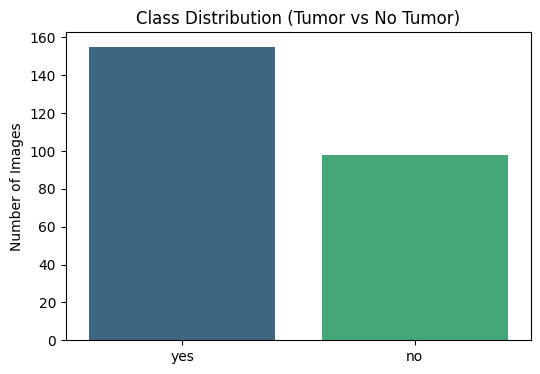

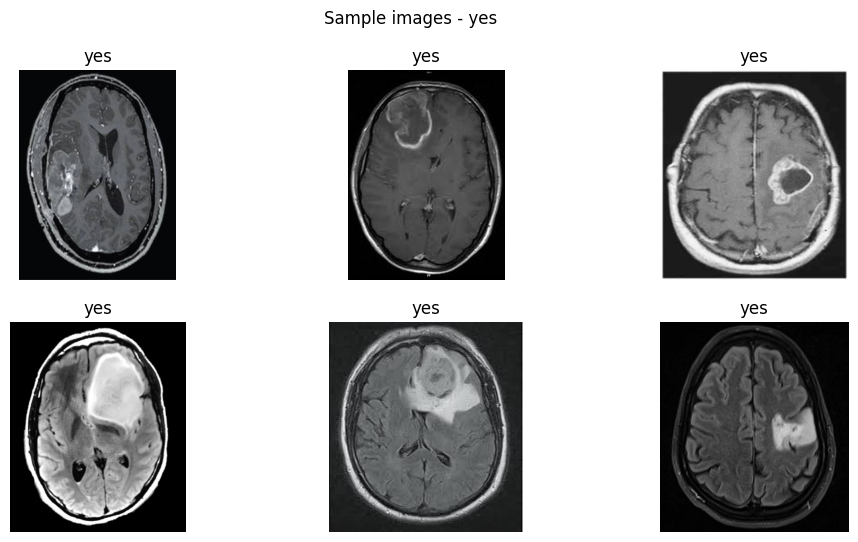

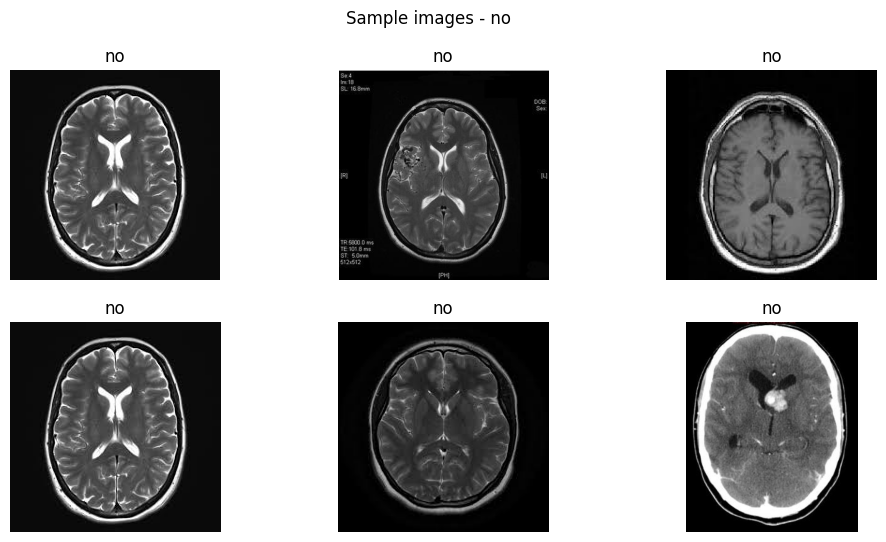

Unique image sizes: [[168 300]
 [173 189]
 [200 200]
 [200 300]
 [201 173]
 [213 236]
 [214 235]
 [218 180]
 [225 225]
 [231 218]]
Total different sizes: 75


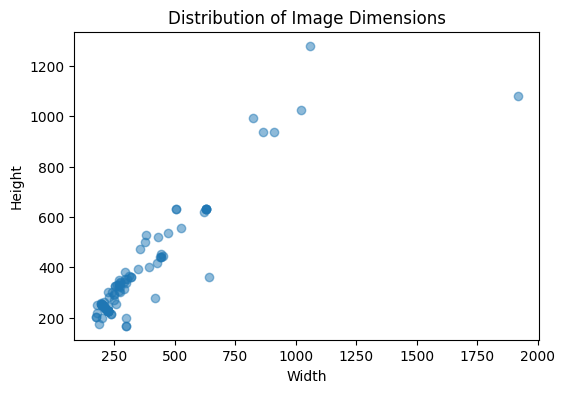

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
import os

# --- Checking class distribution ---
counts = {
    "yes": len(os.listdir(os.path.join(DATA_DIR, "yes"))),
    "no": len(os.listdir(os.path.join(DATA_DIR, "no")))
}
plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
plt.title("Class Distribution (Tumor vs No Tumor)")
plt.ylabel("Number of Images")
plt.show()

# --- Showing random sample images from each class ---
def show_samples(class_name, n=6):
    folder = os.path.join(DATA_DIR, class_name)
    files = os.listdir(folder)
    plt.figure(figsize=(12,6))
    for i, img_file in enumerate(np.random.choice(files, n)):
        img = cv2.imread(os.path.join(folder, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)
    plt.suptitle(f"Sample images - {class_name}")
    plt.show()

show_samples("yes", n=6)
show_samples("no", n=6)

# --- Inspecting image dimensions ---
sizes = []
for cls in ["yes", "no"]:
    folder = os.path.join(DATA_DIR, cls)
    for img_file in os.listdir(folder)[:50]:  # sampling 50 to see
        img = cv2.imread(os.path.join(folder, img_file))
        if img is not None:
            sizes.append(img.shape[:2])  # (height, width)

sizes = np.array(sizes)
unique_sizes = np.unique(sizes, axis=0)
print("Unique image sizes:", unique_sizes[:10])  # showing first 10 unique sizes
print("Total different sizes:", len(unique_sizes))

plt.figure(figsize=(6,4))
plt.scatter(sizes[:,1], sizes[:,0], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Image Dimensions")
plt.show()

The results of EDA:
Class imbalance:

yes (tumor) = 155 images

no (no tumor) = 98 images
→ Slight imbalance → I’ll handle with class weights during training.

Image quality check:

Tumor images clearly show abnormal bright/irregular regions.

Non-tumor images look uniform with no anomalies.
→ Confirms dataset is clean & labeled correctly.

Image size variability:

Found 75 unique image sizes (from ~170px to >1200px).
→ Confirms the need to resize to 224x224 before training.

Pixel intensity histograms (This will show whether tumor images tend to have brighter regions compared to non-tumor.)

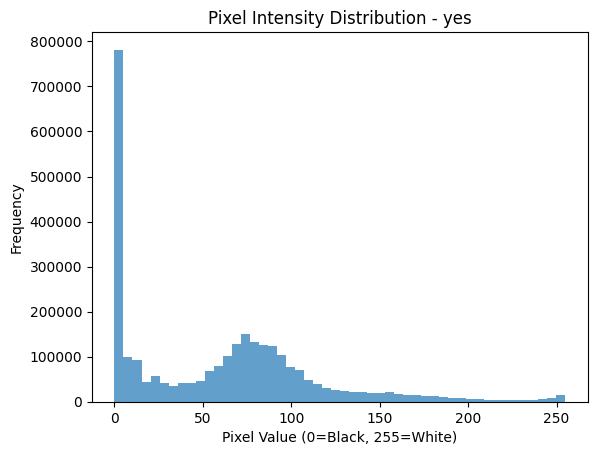

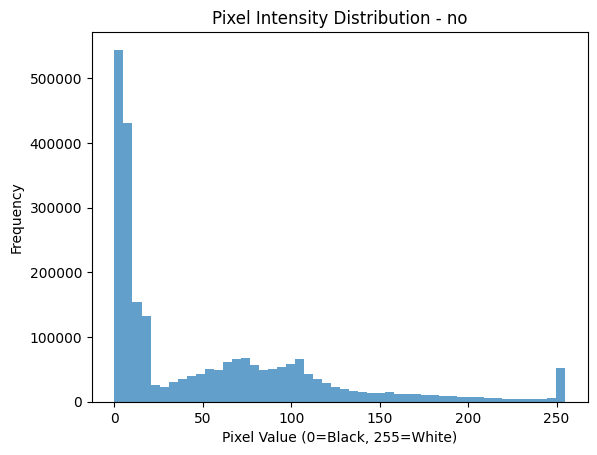

In [ ]:
def plot_intensity_histogram(class_name, n=20):
    folder = os.path.join(DATA_DIR, class_name)
    files = np.random.choice(os.listdir(folder), n, replace=False)
    pixels = []
    for f in files:
        img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
        pixels.extend(img.flatten())

    plt.hist(pixels, bins=50, alpha=0.7)
    plt.title(f"Pixel Intensity Distribution - {class_name}")
    plt.xlabel("Pixel Value (0=Black, 255=White)")
    plt.ylabel("Frequency")
    plt.show()

plot_intensity_histogram("yes")
plot_intensity_histogram("no")


Augmentation sanity check

Showing how augmentation changes images (important in medical imaging to avoid overfitting).

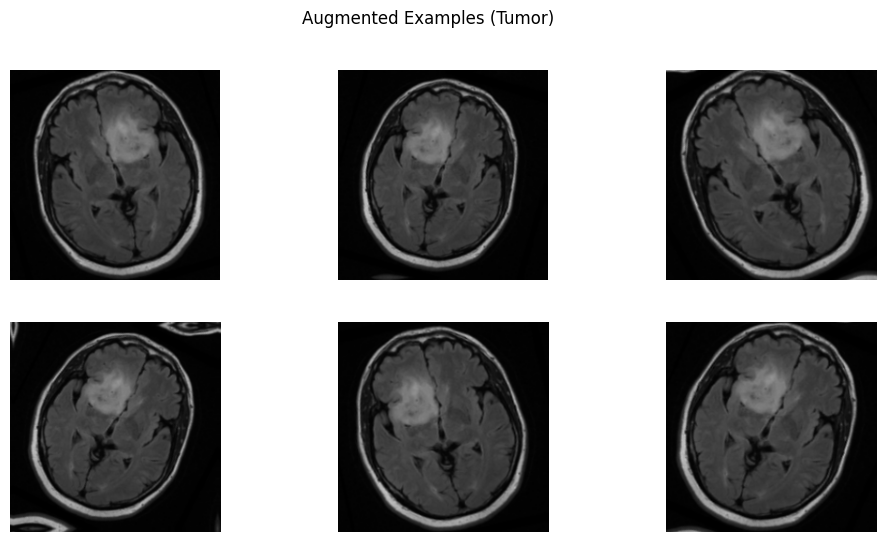

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

folder = os.path.join(DATA_DIR, "yes")
sample_img = cv2.imread(os.path.join(folder, os.listdir(folder)[0]))
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = tf.convert_to_tensor(sample_img)
sample_img = tf.image.resize(sample_img, (224,224))

plt.figure(figsize=(12,6))
for i in range(6):
    augmented = data_augmentation(tf.expand_dims(sample_img, 0))
    plt.subplot(2,3,i+1)
    plt.imshow(augmented[0].numpy().astype("uint8"))
    plt.axis("off")
plt.suptitle("Augmented Examples (Tumor)")
plt.show()

Interpretation of the EDA:

Class imbalance: Tumor (155) vs No Tumor (98). Not too severe, but augmentation and class-weighting will help.

Sample visualization: Both classes are well represented with different imaging variations.

Image sizes: Vary a lot (need resizing, e.g., 224×224).

Pixel intensities: Tumor vs no tumor have different intensity distributions (good signal for classification).

Augmentation sanity check: Confirmed augmentations look realistic and don’t distort medical meaning.

Preparing Data for Training - (data preprocessing and pipeline setup)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Parameters
IMG_SIZE = (224, 224)  # standard size for CNNs
BATCH_SIZE = 32

# Train-validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,   # 80/20 split
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimising the pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


Using Transfer Learning Model

Background: EfficientNetB0 for Brain Tumour Classification

EfficientNetB0 is part of the EfficientNet family of convolutional neural networks (CNNs) introduced by Google AI in 2019.
The key innovation is the compound scaling method, which balances:

Depth (number of layers),

Width (number of channels per layer), and

Resolution (input image size).

Instead of arbitrarily increasing one dimension, EfficientNet scales all three together in a mathematically principled way, leading to models that are both smaller and more accurate compared to older architectures like VGG, ResNet, or Inception.

Why EfficientNetB0 for This Project?

Transfer Learning

EfficientNetB0 is pre-trained on ImageNet (1.2M images, 1000 classes).

This means the model already knows how to detect generic features (edges, textures, shapes, patterns).

For our dataset (only 253 MRI images), transfer learning is critical to avoid overfitting.

Lightweight but Powerful

B0 is the base version of EfficientNet.

It has only 5.3M parameters (compared to ResNet50’s 25M+), making it efficient to train on limited data and perfect for running in Colab with GPU.

Feature Extraction + Fine-Tuning

At first, I freezed the base model (use it only for feature extraction).

Later, I can unfreeze some top layers and fine-tune them on our brain MRI dataset.

This two-step process gives both general vision features and domain-specific learning.

Proven Success in Medical Imaging

EfficientNet has been widely used in cancer detection, X-ray/MRI/CT scan analysis, dermatology imaging, and pathology slide classification.

It’s recognised in academia and industry (including healthcare startups and hospitals) for balancing accuracy and efficiency.

##Model (EfficientNetB0 + proper preprocessing, full fine-tune with tiny LR)

In [ ]:
#   - I already created `train_ds` and `val_ds` tf.data datasets
#     with 224x224 RGB images and binary labels (0 = "no", 1 = "yes").
#   - I set IMG_SIZE = (224, 224) and DATA_DIR points to the
#     root folder that contains two subfolders: "no" and "yes".
#   - TensorFlow/Keras is installed (2.11+ works fine for me).



# === MODEL ===
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input




# Data augmentation I found useful for these MR slices
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),     # flips are fine for this dataset
    layers.RandomRotation(0.15),        # slight rotations are fine too
    layers.RandomZoom(0.15),            # zooming in/out can help
    layers.RandomTranslation(0.1, 0.1),  # small translations are okay
    layers.RandomContrast(0.2),          # small contrast adjustments are okay
], name="aug")

# Build the base model. EfficientNetB0 backbone: no top classifier, start from ImageNet weights
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))


# fine-tune all conv layers, but keep BatchNorm frozen (stability)
for l in base.layers:
    if isinstance(l, layers.BatchNormalization):
        l.trainable = False
    else:
        l.trainable = True

# Full model
inputs = keras.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)  # Data augmentation

# EfficientNet expects a specific pixel scaling; I do it here so
# the saved model “remembers” the exact preprocessing.
x = layers.Lambda(preprocess_input)(x)  

# Run the backbone in training=True so unfrozen layers actually update
x = base(x, training=True)


# Small pooling + head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


# Loss/optimizer/metrics — my “safe” settings for small data
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.05)   # smooth targets a bit
model.compile(optimizer=keras.optimizers.Adam(5e-6),
              loss=loss,
              metrics=["accuracy", keras.metrics.AUC(name="auc")])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,129,629 (15.75 MB)

 Non-trainable params: 84,039 (328.28 KB)

##TClass weights (handles 155 vs 98 imbalance)

In [ ]:
# ============================================================
# Class weights (I have more “yes” than “no”)
# ============================================================
# I compute weights inversely proportional to class frequency so each class
# contributes similarly to the loss during training.


# Discover class folders in DATA_DIR and count files in each
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR,d))])
counts  = {c: len(list((pathlib.Path(DATA_DIR)/c).glob("*"))) for c in classes}
total   = sum(counts.values())

# Classic inverse-frequency weighting: total/(num_classes * count_c)
class_weights = {i: total/(len(classes)*counts[c]) for i,c in enumerate(classes)}
print("Class counts:", counts)
print("Class weights:", class_weights)

Class counts: {'no': 98, 'yes': 155}
Class weights: {0: 1.2908163265306123, 1: 0.8161290322580645}


##Callbacks + Train (EarlyStopping may stop < epochs)

In [ ]:
# === TRAIN ===
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



# Callbacks + training loop
# ============================================================
# I monitor AUC (validation) because it matched my goal better than accuracy.
# - ModelCheckpoint: save only the best epoch by AUC
# - ReduceLROnPlateau: gently lower LR if val_loss gets stuck
# - EarlyStopping: stop once AUC plateaus and restore the best weights

callbacks = [
    ModelCheckpoint("best_model.h5", monitor="val_auc", mode="max",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor="val_auc", mode="max",
                  patience=20, min_delta=1e-4,
                  restore_best_weights=True, verbose=1),
]

EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4515 - auc: 0.4227 - loss: 0.7861
Epoch 1: val_auc improved from -inf to 0.51426, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step - accuracy: 0.4542 - auc: 0.4291 - loss: 0.7837 - val_accuracy: 0.4000 - val_auc: 0.5143 - val_loss: 0.7756 - learning_rate: 5.0000e-06
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5597 - auc: 0.5365 - loss: 0.7302
Epoch 2: val_auc improved from 0.51426 to 0.58111, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.5531 - auc: 0.5384 - loss: 0.7288 - val_accuracy: 0.4000 - val_auc: 0.5811 - val_loss: 0.7487 - learning_rate: 5.0000e-06
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4935 - auc: 0.5585 - loss: 0.7166
Epoch 3: val_auc improved from 0.58111 to 0.64260, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.4983 - auc: 0.5593 - loss: 0.7158 - val_accuracy: 0.4200 - val_auc: 0.6426 - val_loss: 0.7234 - learning_rate: 5.0000e-06
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5758 - auc: 0.5879 - loss: 0.6984
Epoch 4: val_auc improved from 0.64260 to 0.68627, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.5728 - auc: 0.5865 - loss: 0.6986 - val_accuracy: 0.4400 - val_auc: 0.6863 - val_loss: 0.7080 - learning_rate: 5.0000e-06
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5713 - auc: 0.5885 - loss: 0.6881
Epoch 5: val_auc improved from 0.68627 to 0.74064, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.5725 - auc: 0.5903 - loss: 0.6876 - val_accuracy: 0.4400 - val_auc: 0.7406 - val_loss: 0.6933 - learning_rate: 5.0000e-06
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5333 - auc: 0.6163 - loss: 0.6793
Epoch 6: val_auc improved from 0.74064 to 0.76114, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.5288 - auc: 0.6127 - loss: 0.6805 - val_accuracy: 0.5000 - val_auc: 0.7611 - val_loss: 0.6789 - learning_rate: 5.0000e-06
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5883 - auc: 0.6357 - loss: 0.6736
Epoch 7: val_auc improved from 0.76114 to 0.77540, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.5942 - auc: 0.6395 - loss: 0.6720 - val_accuracy: 0.5800 - val_auc: 0.7754 - val_loss: 0.6685 - learning_rate: 5.0000e-06
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5855 - auc: 0.6563 - loss: 0.6568
Epoch 8: val_auc improved from 0.77540 to 0.78521, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.5868 - auc: 0.6580 - loss: 0.6560 - val_accuracy: 0.6600 - val_auc: 0.7852 - val_loss: 0.6582 - learning_rate: 5.0000e-06
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5841 - auc: 0.5963 - loss: 0.6880
Epoch 9: val_auc improved from 0.78521 to 0.81283, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.5838 - auc: 0.6000 - loss: 0.6864 - val_accuracy: 0.6600 - val_auc: 0.8128 - val_loss: 0.6502 - learning_rate: 5.0000e-06
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6085 - auc: 0.6432 - loss: 0.6778
Epoch 10: val_auc improved from 0.81283 to 0.81907, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.6149 - auc: 0.6531 - loss: 0.6727 - val_accuracy: 0.6800 - val_auc: 0.8191 - val_loss: 0.6433 - learning_rate: 5.0000e-06
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5632 - auc: 0.6407 - loss: 0.6680
Epoch 11: val_auc improved from 0.81907 to 0.82531, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.5697 - auc: 0.6460 - loss: 0.6658 - val_accuracy: 0.7000 - val_auc: 0.8253 - val_loss: 0.6376 - learning_rate: 5.0000e-06
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7073 - auc: 0.7573 - loss: 0.6051
Epoch 12: val_auc improved from 0.82531 to 0.83333, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.7014 - auc: 0.7532 - loss: 0.6081 - val_accuracy: 0.6600 - val_auc: 0.8333 - val_loss: 0.6342 - learning_rate: 5.0000e-06
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6616 - auc: 0.7162 - loss: 0.6371
Epoch 13: val_auc improved from 0.83333 to 0.83779, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.6639 - auc: 0.7192 - loss: 0.6348 - val_accuracy: 0.6600 - val_auc: 0.8378 - val_loss: 0.6313 - learning_rate: 5.0000e-06
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7196 - auc: 0.7795 - loss: 0.6026
Epoch 14: val_auc improved from 0.83779 to 0.84581, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.7220 - auc: 0.7810 - loss: 0.6009 - val_accuracy: 0.7000 - val_auc: 0.8458 - val_loss: 0.6279 - learning_rate: 5.0000e-06
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7202 - auc: 0.7848 - loss: 0.5882
Epoch 15: val_auc improved from 0.84581 to 0.85383, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.7207 - auc: 0.7827 - loss: 0.5892 - val_accuracy: 0.7200 - val_auc: 0.8538 - val_loss: 0.6196 - learning_rate: 5.0000e-06
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6887 - auc: 0.7503 - loss: 0.6022
Epoch 16: val_auc improved from 0.85383 to 0.85829, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.6889 - auc: 0.7500 - loss: 0.6029 - val_accuracy: 0.7400 - val_auc: 0.8583 - val_loss: 0.6122 - learning_rate: 5.0000e-06
Epoch 17/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7061 - auc: 0.7647 - loss: 0.5982
Epoch 17: val_auc improved from 0.85829 to 0.86096, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.7078 - auc: 0.7663 - loss: 0.5973 - val_accuracy: 0.7400 - val_auc: 0.8610 - val_loss: 0.6112 - learning_rate: 5.0000e-06
Epoch 18/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6835 - auc: 0.7561 - loss: 0.6075
Epoch 18: val_auc improved from 0.86096 to 0.86364, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.6800 - auc: 0.7522 - loss: 0.6094 - val_accuracy: 0.7200 - val_auc: 0.8636 - val_loss: 0.6083 - learning_rate: 5.0000e-06
Epoch 19/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7121 - auc: 0.7532 - loss: 0.5956
Epoch 19: val_auc improved from 0.86364 to 0.86809, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.7161 - auc: 0.7598 - loss: 0.5925 - val_accuracy: 0.7400 - val_auc: 0.8681 - val_loss: 0.6012 - learning_rate: 5.0000e-06
Epoch 20/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7348 - auc: 0.8166 - loss: 0.5554
Epoch 20: val_auc improved from 0.86809 to 0.86988, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.7402 - auc: 0.8188 - loss: 0.5535 - val_accuracy: 0.7400 - val_auc: 0.8699 - val_loss: 0.5947 - learning_rate: 5.0000e-06
Epoch 21/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7681 - auc: 0.8864 - loss: 0.5035
Epoch 21: val_auc improved from 0.86988 to 0.88057, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.7638 - auc: 0.8787 - loss: 0.5105 - val_accuracy: 0.7600 - val_auc: 0.8806 - val_loss: 0.5841 - learning_rate: 5.0000e-06
Epoch 22/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7574 - auc: 0.8404 - loss: 0.5483
Epoch 22: val_auc improved from 0.88057 to 0.88324, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.7538 - auc: 0.8358 - loss: 0.5513 - val_accuracy: 0.7400 - val_auc: 0.8832 - val_loss: 0.5835 - learning_rate: 5.0000e-06
Epoch 23/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7640 - auc: 0.8440 - loss: 0.5224
Epoch 23: val_auc did not improve from 0.88324
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.7645 - auc: 0.8447 - loss: 0.5232 - val_accuracy: 0.7400 - val_auc: 0.8832 - val_loss: 0.5839 - learning_rate: 5.0000e-06
Epoch 24/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7559 - auc: 0.8437 - loss: 0.5381
Epoch 24: val_auc improved from 0.88324 to 0.88681, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.7587 - auc: 0.8456 - loss: 0.5353 - val_accuracy: 0.7400 - val_auc: 0.8868 - val_loss: 0.5799 - learning_rate: 5.0000e-06
Epoch 25/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6969 - auc: 0.8264 - loss: 0.5434
Epoch 25: val_auc improved from 0.88681 to 0.88770, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.7034 - auc: 0.8313 - loss: 0.5390 - val_accuracy: 0.7400 - val_auc: 0.8877 - val_loss: 0.5722 - learning_rate: 5.0000e-06
Epoch 26/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8027 - auc: 0.8553 - loss: 0.5144
Epoch 26: val_auc improved from 0.88770 to 0.89037, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - accuracy: 0.7966 - auc: 0.8517 - loss: 0.5173 - val_accuracy: 0.7600 - val_auc: 0.8904 - val_loss: 0.5620 - learning_rate: 5.0000e-06
Epoch 27/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8254 - auc: 0.8816 - loss: 0.4918
Epoch 27: val_auc improved from 0.89037 to 0.89572, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.8219 - auc: 0.8785 - loss: 0.4944 - val_accuracy: 0.8000 - val_auc: 0.8957 - val_loss: 0.5513 - learning_rate: 5.0000e-06
Epoch 28/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7334 - auc: 0.8503 - loss: 0.5165
Epoch 28: val_auc did not improve from 0.89572
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.7378 - auc: 0.8536 - loss: 0.5130 - val_accuracy: 0.8000 - val_auc: 0.8957 - val_loss: 0.5431 - learning_rate: 5.0000e-06
Epoch 29/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8438 - auc: 0.9192 - loss: 0.4484
Epoch 29: val_auc improved from 0.89572 to 0.90196, saving model to best_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.8400 - auc: 0.9137 - loss: 0.4542 - val_accuracy: 0.8200 - val_auc: 0.9020 - val_loss: 0.5346 - learning_rate: 5.0000e-06
Epoch 30/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7382 - auc: 0.8135 - loss: 0.5508
Epoch 30: val_auc did not improve from 0.90196
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7389 - auc: 0.8168 - loss: 0.5474 - val_accuracy: 0.8200 - val_auc: 0.9011 - val_loss: 0.5292 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 29.


##Evaluate (pick best threshold) + download model

In [ ]:
# === EVALUATE & DOWNLOAD ===
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from google.colab import files

# ============================================================
# Evaluate on val set, pick a decision threshold, download
# ============================================================
# I don’t want to hardcode 0.5. Instead, I compute Youden’s J (TPR - FPR)
# on the validation scores and keep the threshold that maximizes it.
# Collect labels and raw model scores on the whole validation set
y_true, y_score = [], []
for x, y in val_ds:
    y_true.extend(y.numpy().astype(int))
    y_score.extend(model.predict(x, verbose=0).ravel())
y_true = np.array(y_true); y_score = np.array(y_score)


# ROC + best threshold via Youden’s J
fpr, tpr, thr = roc_curve(y_true, y_score)
best_thr = thr[np.argmax(tpr - fpr)]
y_pred = (y_score >= best_thr).astype(int)

# Report
print(f"Best threshold: {best_thr:.3f} | AUC: {roc_auc_score(y_true, y_score):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=classes))

# I already saved best weights during training, so I just download that file.
# (I later convert it to .keras in a small utility cell.)
files.download("best_model.h5")

Best threshold: 0.503 | AUC: 0.902
Confusion matrix:
 [[15  2]
 [ 7 26]]
              precision    recall  f1-score   support

          no       0.68      0.88      0.77        17
         yes       0.93      0.79      0.85        33

    accuracy                           0.82        50
   macro avg       0.81      0.84      0.81        50
weighted avg       0.84      0.82      0.82        50



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

uploading the model

In [ ]:
from google.colab import files
files.upload()  # choose best_model.h5


Saving best_model.h5 to best_model.h5
Buffered data was truncated after reaching the output size limit.

Convert .h5 → .keras

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import preprocess_input

m = keras.models.load_model(
    "best_model.h5", compile=False,
    custom_objects={"preprocess_input": preprocess_input}
)
m.save("best_model.keras", include_optimizer=False)

Download:

In [ ]:
from google.colab import files
files.download("best_model.keras")